
# Deep Learning Project 3 &nbsp;—&nbsp; Adversarial Attacks

1. **Baseline** evaluation of ResNet‑34 on the provided ImageNet subset
2. **FGSM** single‑step $L_\infty$ attack
3. **$L_2$** norm deviation
3. **$L_2$** norm deviation normalized to match $L_\infty$ energy
4. **PGD** multi‑step $L_\infty$ attack
5. **Patch PGD** — perturbation limited to a 32 × 32 region
6. **Transferability** assessment on DenseNet‑121

## Setup

In this we setup the environment: imports, constants, etc.

### Imports

In [11]:
import torch, torchvision, json, numpy as np, os, pkg_resources, random
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import textwrap, nbformat as nbf, json, os, numpy as np, matplotlib.pyplot as plt

### Constants

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# paths
DATASET_DIR = Path('/kaggle/input/dl-final-project-test-dataset/TestDataSet')  # adjust if running locally
WORK_DIR = Path('/kaggle/working') if Path('/kaggle/input').exists() else Path('./')
OUT_DIR = WORK_DIR / 'adv_outputs'
OUT_DIR.mkdir(exist_ok=True)

# attack hyper‑parameters
EPSILON = 0.02                       # FGSM / PGD budget
PGD_STEPS, PGD_ALPHA = 10, EPSILON/10*1.25
PATCH_SIZE, PATCH_EPS = 32, 0.3
PATCH_STEPS, PATCH_ALPHA = 20, PATCH_EPS/20*1.2

# normalization tensors
mean = torch.tensor([0.485,0.456,0.406], device=device).view(3,1,1)
std  = torch.tensor([0.229,0.224,0.225], device=device).view(3,1,1)
LOWER, UPPER = (0-mean)/std, (1-mean)/std

Device: cuda


### Visualization helpers

In [13]:
def show_triplet(model, orig, adv, idx=0, class_map=None):
    """
    Displays: original, adversarial, diff, normalized diff,
    and prints top‑5 probs for both images.
    """
    model.eval()
    o = orig[idx].cpu()

    a = adv[idx].cpu()
    
    unnorm = lambda x: (x * std.cpu()) + mean.cpu()
    
    o_img = unnorm(o).clamp(0,1).permute(1,2,0).numpy()
    a_img = unnorm(a).clamp(0,1).permute(1,2,0).numpy()
    diff  = (a_img - o_img)
    diff_n= (diff - diff.min()) / (diff.max() - diff.min() + 1e-6)  # 0‑1 scaling
    
    fig, axs = plt.subplots(1,4, figsize=(14,3))
    titles = ['Original', 'Adversarial', 'Raw diff', 'Norm diff']
    for ax, img, t in zip(axs, [o_img, a_img, diff, diff_n], titles):
        ax.imshow(img)
        ax.set_title(t)
        ax.axis('off')
    plt.show()
    
    soft = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        p_o = soft(model(orig.to(device)))[idx]
        p_a = soft(model(adv.to(device)))[idx]
    top_o = torch.topk(p_o, 5)
    top_a = torch.topk(p_a, 5)
    
    def format_top(top):
        return [(int(k), float(v)*100) for v,k in zip(top.values, top.indices)]
    print('Top‑5 Original:', format_top(top_o))
    print('Top‑5 Adversarial:', format_top(top_a))

### Stratergy tester

In [14]:
def run_attack(name, attack_fn, *, save_dir, viz=True, **attack_kwargs):
    """
    attack_fn(model, imgs, lbls, **attack_kwargs) -> adversarial_batch (tensor, same device)
    Computes top‑1 / top‑5 on the fly, saves images, optional visual for 1st batch.
    """
    save_dir.mkdir(parents=True, exist_ok=True)
    model = resnet34.eval()                 # global model
    filelist = [p for p, _ in ds.samples]
    top1 = top5 = 0
    ptr = 0
    for batch_idx, (imgs, lbl) in enumerate(tqdm(loader, desc=name)):
        adv = attack_fn(model, imgs, lbl, **attack_kwargs)
        
        # save
        for img_t, src in zip((adv*std+mean).clamp(0,1), filelist[ptr:ptr+len(imgs)]):
            out_path = save_dir / Path(src).relative_to(DATASET_DIR)
            out_path.parent.mkdir(parents=True, exist_ok=True)
            transforms.ToPILImage()(img_t.cpu()).save(out_path)
        ptr += len(imgs)
        
        # metrics
        with torch.no_grad():
            a1, a5 = accuracy(model(adv.to(device)), lbl.to(device))
            top1 += a1 * imgs.size(0)
            top5 += a5 * imgs.size(0)
        
        # visualize
        if viz and batch_idx <= 3:
            show_triplet(model, imgs, adv, idx=0)
    
    top1 /= len(ds)
    top5 /= len(ds)
    print(f'{name} — top‑1 {top1:.2f}% | top‑5 {top5:.2f}%')

### Dataset loader with correct ImageNet labels

In [15]:
# Build mapping by matching folder order to labels_list.json
import json, os
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1.  Ordered list of target ImageNet IDs (401‑500)
with open(DATASET_DIR / 'labels_list.json') as f:
    target_ids = [int(line.split(':')[0]) for line in json.load(f)]

# 2.  Alphabetical list of class folders
subdirs = sorted(entry.name for entry in os.scandir(DATASET_DIR) if entry.is_dir())

assert len(subdirs) == len(target_ids), "folder count ≠ label count"

# 3.  folder → true ImageNet ID
folder_to_idx = {folder: idx for folder, idx in zip(subdirs, target_ids)}

# 4.  Custom ImageFolder that uses this mapping
class ImageNetSubset(datasets.ImageFolder):
    def find_classes(self, directory):
        return subdirs, folder_to_idx

def get_loaders(batch_size=64):
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean.squeeze().tolist(), std.squeeze().tolist())
    ])
    ds = ImageNetSubset(str(DATASET_DIR), transform=tfm)
    return DataLoader(ds, batch_size=batch_size, shuffle=False), ds

def accuracy(output, target, topk=(1, 5)):
    """top‑k accuracy, returns list like [top1, top5]"""
    maxk = max(topk)
    _, pred = output.topk(maxk, 1, True, True)   # preds shape: [B, maxk]
    pred = pred.t()                              # -> [maxk, B]
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        res.append(correct[:k].reshape(-1).float().sum(0).item() * 100.0 / target.size(0))
    return res

## 1. Baseline accuracy

### 1.1 Evaluate ResNet‑34

In [16]:
loader, ds = get_loaders()
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device).eval()

top1=top5=0
with torch.no_grad():
    for imgs,lbl in tqdm(loader):
        out = resnet34(imgs.to(device))
        a1,a5=accuracy(out,lbl.to(device))
        top1+=a1*imgs.size(0)
        top5+=a5*imgs.size(0)
n=len(ds)
top1/=n
top5/=n
print(f'Baseline – top‑1 {top1:.2f}% | top‑5 {top5:.2f}%')

  0%|          | 0/8 [00:00<?, ?it/s]

Baseline – top‑1 76.00% | top‑5 94.20%


## 2. FGSM attack

### 2.1 Generate $L_\infty$ FGSM examples

In [17]:
def fgsm(model, imgs, lbls, eps):
    imgs=imgs.clone().detach().to(device).requires_grad_(True)
    loss=F.cross_entropy(model(imgs), lbls.to(device))
    loss.backward()
    adv = imgs + eps*imgs.grad.sign()
    return torch.clamp(adv, LOWER, UPPER).detach()

FGSM:   0%|          | 0/8 [00:00<?, ?it/s]

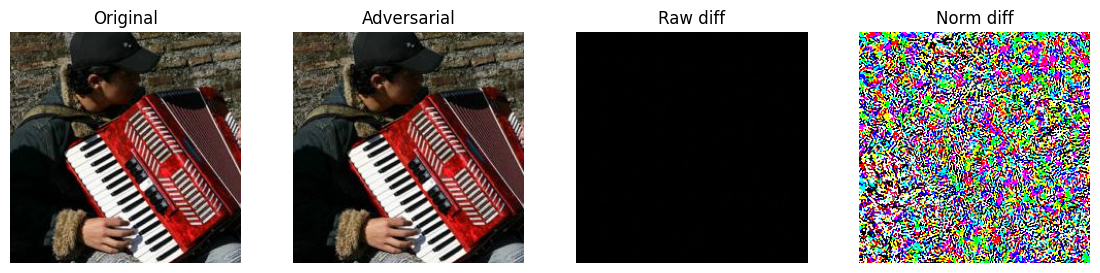

Top‑5 Original: [(401, 99.97320771217346), (881, 0.006146683153929189), (579, 0.0054672393162036315), (541, 0.0011557671314221807), (652, 0.0010711120012274478)]
Top‑5 Adversarial: [(401, 53.6803662776947), (621, 2.9177937656641006), (595, 1.8187113106250763), (579, 1.4044391922652721), (442, 1.3760964386165142)]


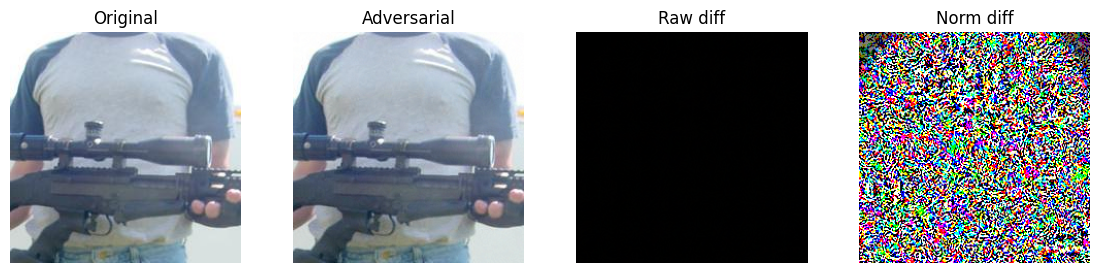

Top‑5 Original: [(413, 77.32294201850891), (764, 19.478987157344818), (465, 2.963506057858467), (652, 0.1414745580404997), (597, 0.030899600824341178)]
Top‑5 Adversarial: [(764, 60.573744773864746), (652, 15.513880550861359), (413, 13.036368787288666), (465, 4.536129906773567), (744, 0.7914919406175613)]


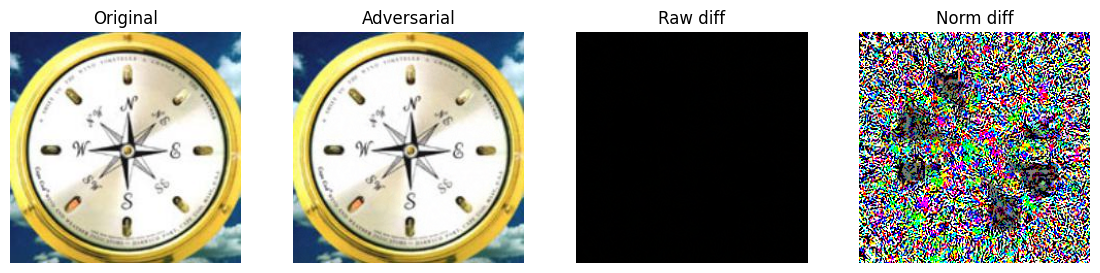

Top‑5 Original: [(635, 75.00854730606079), (409, 17.02546328306198), (426, 3.1481746584177017), (826, 3.137737885117531), (892, 0.6500579882413149)]
Top‑5 Adversarial: [(635, 98.93251657485962), (409, 0.9265892207622528), (826, 0.06458258139900863), (892, 0.018405646551400423), (880, 0.00920995807973668)]


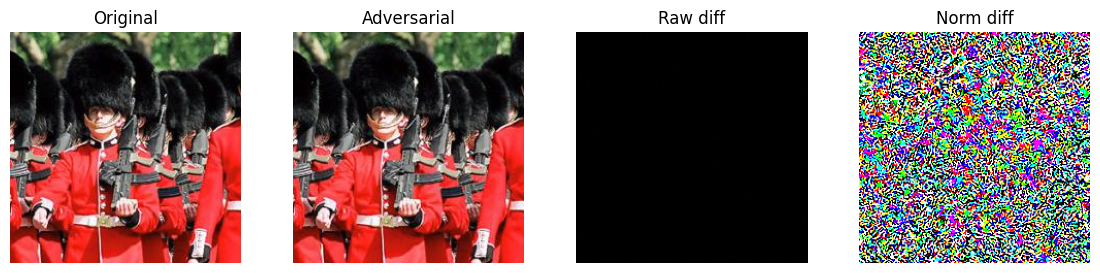

Top‑5 Original: [(439, 99.99955892562866), (223, 0.00020019629118905868), (244, 7.345163339778082e-05), (715, 2.6426729959894146e-05), (652, 2.1500336799817887e-05)]
Top‑5 Adversarial: [(223, 83.59425067901611), (439, 5.394227430224419), (254, 2.0430680364370346), (179, 0.7268136367201805), (245, 0.5913812201470137)]
FGSM — top‑1 6.20% | top‑5 35.40%


In [18]:
run_attack("FGSM", fgsm,
           save_dir = OUT_DIR / "FGSM",
           eps = EPSILON)

## 3. Improved attacks

## 3.1 $L_2$ normalized deviation

In [19]:
def fgm_l2(model, imgs, lbls, eps):
    imgs = imgs.clone().detach().to(device).requires_grad_(True)
    loss = F.cross_entropy(model(imgs), lbls.to(device)); loss.backward()
    grad = imgs.grad
    # per‑sample L2 normalisation
    grad_norm = torch.norm(grad.view(grad.size(0), -1), dim=1, keepdim=True).view(-1,1,1,1)
    perturb = eps * grad / (grad_norm + 1e-10)
    adv = imgs + perturb
    return torch.clamp(adv, LOWER, UPPER).detach()

FGM‑L2:   0%|          | 0/8 [00:00<?, ?it/s]

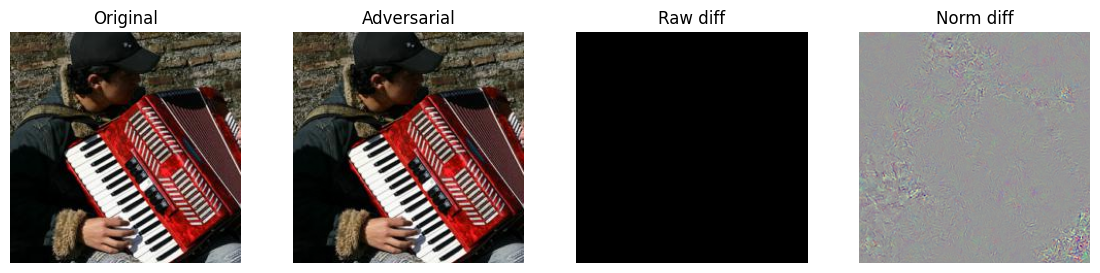

Top‑5 Original: [(401, 99.97320771217346), (881, 0.006146683153929189), (579, 0.0054672393162036315), (541, 0.0011557671314221807), (652, 0.0010711120012274478)]
Top‑5 Adversarial: [(401, 99.97108578681946), (881, 0.006557832966791466), (579, 0.00585168381803669), (541, 0.0012386070920911152), (652, 0.0011652649845927954)]


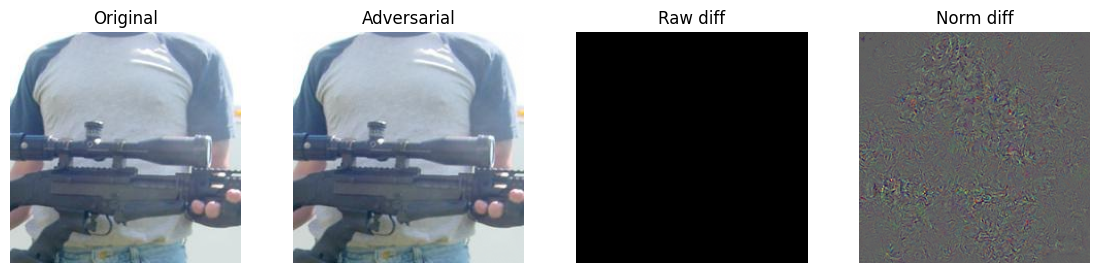

Top‑5 Original: [(413, 77.32294201850891), (764, 19.478987157344818), (465, 2.963506057858467), (652, 0.1414745580404997), (597, 0.030899600824341178)]
Top‑5 Adversarial: [(413, 76.28942131996155), (764, 20.245787501335144), (465, 3.2059460878372192), (652, 0.1568567822687328), (597, 0.03290707245469093)]


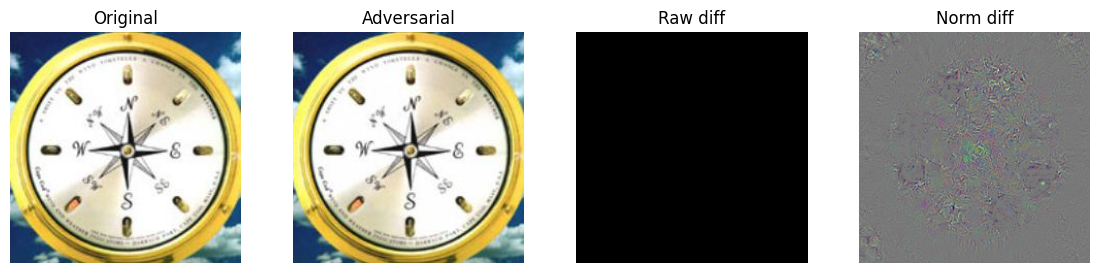

Top‑5 Original: [(635, 75.00854730606079), (409, 17.02546328306198), (426, 3.1481746584177017), (826, 3.137737885117531), (892, 0.6500579882413149)]
Top‑5 Adversarial: [(635, 75.59388279914856), (409, 16.72521084547043), (826, 3.06114349514246), (426, 2.9907768592238426), (892, 0.6322179920971394)]


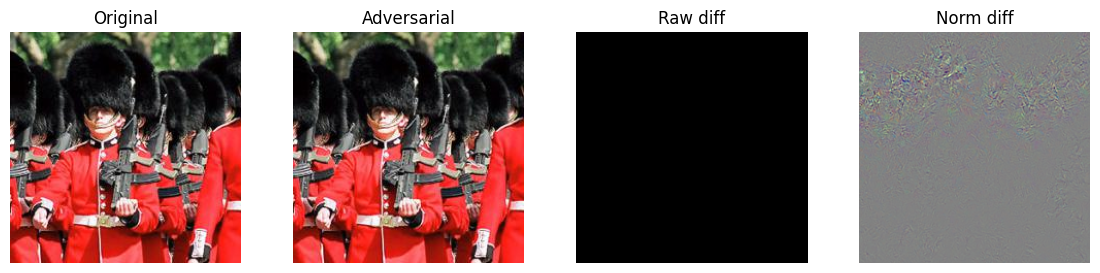

Top‑5 Original: [(439, 99.99955892562866), (223, 0.00020019629118905868), (244, 7.345163339778082e-05), (715, 2.6426729959894146e-05), (652, 2.1500336799817887e-05)]
Top‑5 Adversarial: [(439, 99.99948740005493), (223, 0.00024631171982036904), (244, 8.536075029041967e-05), (715, 2.9625883257722307e-05), (652, 2.4151293587237888e-05)]
FGM‑L2 — top‑1 74.40% | top‑5 93.40%


In [20]:
run_attack("FGM‑L2", fgm_l2,
           save_dir = OUT_DIR / "FGM_L2",
           eps = EPSILON)

## 3.1 $L_2$ deviation ($\sqrt{d}$ scaled)

FGM‑L2:   0%|          | 0/8 [00:00<?, ?it/s]

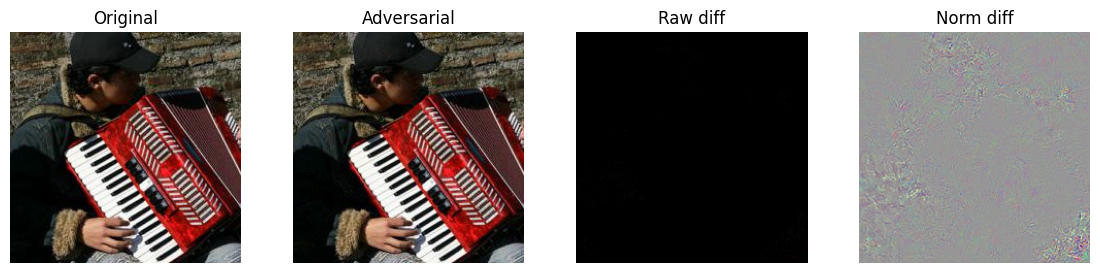

Top‑5 Original: [(401, 99.97320771217346), (881, 0.006146683153929189), (579, 0.0054672393162036315), (541, 0.0011557671314221807), (652, 0.0010711120012274478)]
Top‑5 Adversarial: [(401, 53.86281609535217), (621, 2.297428995370865), (579, 1.6837146133184433), (442, 1.5353667549788952), (408, 1.3717859983444214)]


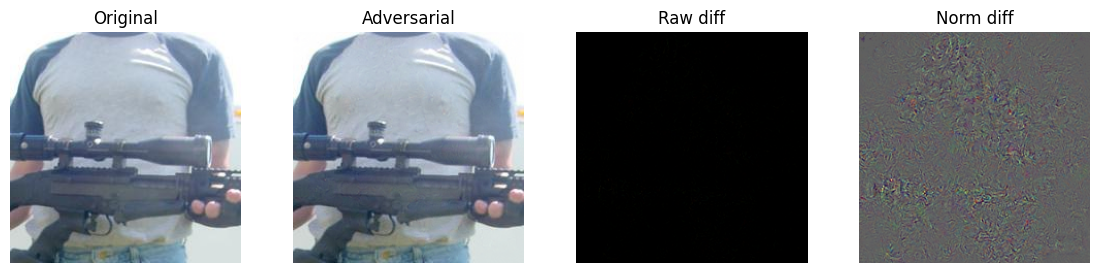

Top‑5 Original: [(413, 77.32294201850891), (764, 19.478987157344818), (465, 2.963506057858467), (652, 0.1414745580404997), (597, 0.030899600824341178)]
Top‑5 Adversarial: [(764, 57.185572385787964), (652, 19.028501212596893), (413, 13.160373270511627), (465, 5.2369773387908936), (744, 0.8066242560744286)]


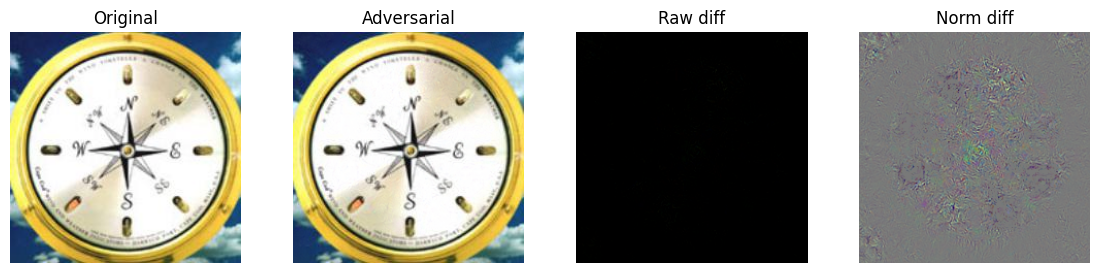

Top‑5 Original: [(635, 75.00854730606079), (409, 17.02546328306198), (426, 3.1481746584177017), (826, 3.137737885117531), (892, 0.6500579882413149)]
Top‑5 Adversarial: [(635, 99.17480945587158), (409, 0.6794099230319262), (826, 0.04779947339557111), (892, 0.013953687448520213), (426, 0.009252107702195644)]


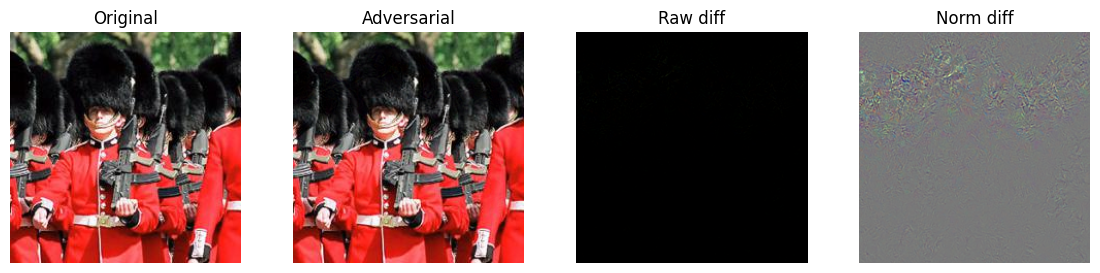

Top‑5 Original: [(439, 99.99955892562866), (223, 0.00020019629118905868), (244, 7.345163339778082e-05), (715, 2.6426729959894146e-05), (652, 2.1500336799817887e-05)]
Top‑5 Adversarial: [(223, 55.55092096328735), (439, 27.842387557029724), (254, 1.9836174324154854), (179, 0.9362611919641495), (205, 0.8859002031385899)]
FGM‑L2 — top‑1 6.00% | top‑5 35.00%


In [21]:
sample_img = ds[0][0]
d = sample_img.numel()
eps_l2  = EPSILON * (d ** 0.5)
run_attack("FGM‑L2", fgm_l2,
           save_dir = OUT_DIR / "FGM_L2",
           eps = eps_l2)

## 4. PGD attack

### 4.1 Multi‑step PGD generation

In [22]:
def pgd(model, imgs, lbls, eps, alpha, steps):
    imgs=imgs.clone().detach().to(device)
    ori=imgs.clone()
    for _ in range(steps):
        imgs.requires_grad=True
        loss=F.cross_entropy(model(imgs),lbls.to(device))
        model.zero_grad()
        loss.backward()
        adv=imgs+alpha*imgs.grad.sign()
        eta=torch.clamp(adv-ori,min=-eps,max=eps)
        imgs=torch.clamp(ori+eta, LOWER, UPPER).detach()
    return imgs

PGD:   0%|          | 0/8 [00:00<?, ?it/s]

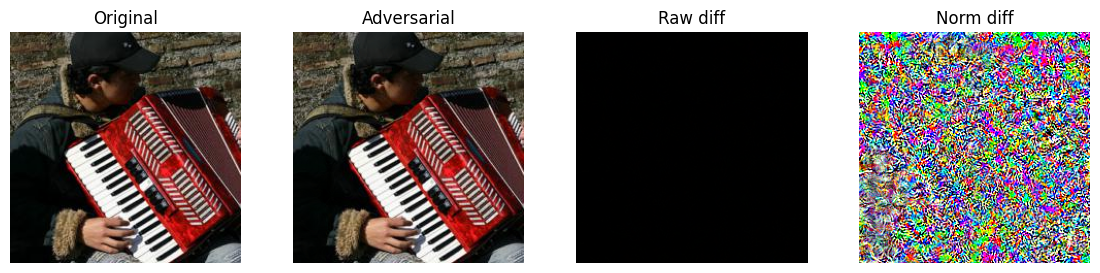

Top‑5 Original: [(401, 99.97320771217346), (881, 0.006146683153929189), (579, 0.0054672393162036315), (541, 0.0011557671314221807), (652, 0.0010711120012274478)]
Top‑5 Adversarial: [(621, 43.76092255115509), (595, 17.742495238780975), (573, 7.498786598443985), (866, 4.1225869208574295), (408, 3.2699190080165863)]


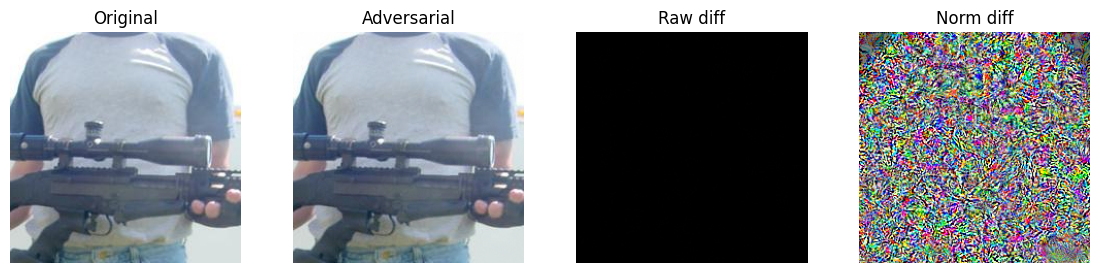

Top‑5 Original: [(413, 77.32294201850891), (764, 19.478987157344818), (465, 2.963506057858467), (652, 0.1414745580404997), (597, 0.030899600824341178)]
Top‑5 Adversarial: [(465, 99.99998807907104), (524, 6.9616461928490025e-06), (411, 2.2885853212528673e-06), (461, 1.7066593471781744e-06), (652, 1.0378372605757136e-07)]


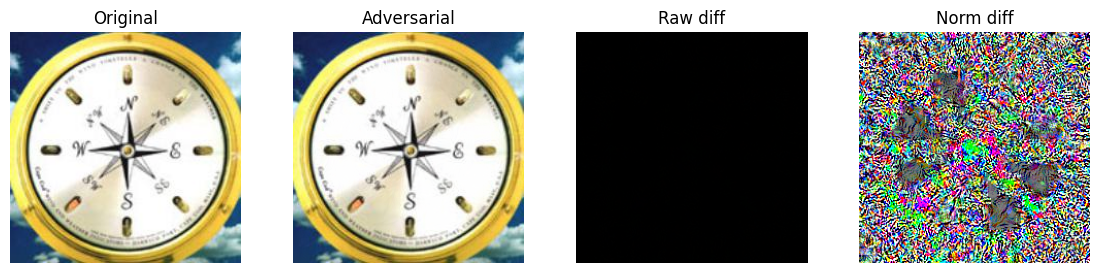

Top‑5 Original: [(635, 75.00854730606079), (409, 17.02546328306198), (426, 3.1481746584177017), (826, 3.137737885117531), (892, 0.6500579882413149)]
Top‑5 Adversarial: [(635, 99.9944806098938), (409, 0.004454080408322625), (826, 0.0005578003765549511), (684, 7.608425676153274e-05), (778, 5.573741646003327e-05)]


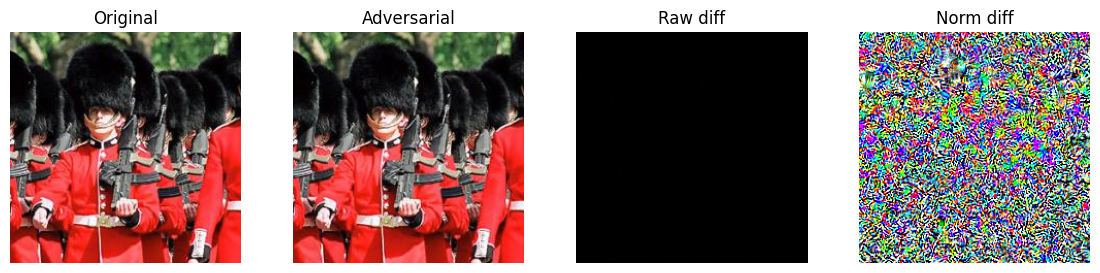

Top‑5 Original: [(439, 99.99955892562866), (223, 0.00020019629118905868), (244, 7.345163339778082e-05), (715, 2.6426729959894146e-05), (652, 2.1500336799817887e-05)]
Top‑5 Adversarial: [(223, 99.94933605194092), (254, 0.01136158243753016), (224, 0.009458058775635436), (245, 0.008077872917056084), (227, 0.004816296132048592)]
PGD — top‑1 0.20% | top‑5 12.40%


In [23]:
run_attack("PGD", pgd,
           save_dir = OUT_DIR / "PGD",
           eps = EPSILON,
           alpha = PGD_ALPHA,
           steps = PGD_STEPS)

## 5. Localized 32 × 32 Patch PGD

### 5.1 Patch‑constrained attack

In [26]:
def patch_pgd(model, imgs, lbls, eps, alpha, steps, size):
    imgs=imgs.clone().detach().to(device)
    ori=imgs.clone()
    B,C,H,W=imgs.shape
    y0=torch.randint(0,H-size+1,(B,),device=device)
    x0=torch.randint(0,W-size+1,(B,),device=device)
    mask=torch.zeros_like(imgs)
    for i in range(B):
        mask[i,:, y0[i]:y0[i]+size, x0[i]:x0[i]+size]=1
    for _ in range(steps):
        imgs.requires_grad=True
        loss=F.cross_entropy(model(imgs), lbls.to(device))
        model.zero_grad()
        loss.backward()
        grad = imgs.grad.sign()*mask
        adv = imgs + alpha*grad
        eta = torch.clamp(adv-ori,min=-eps,max=eps)*mask
        imgs = torch.clamp(ori+eta, LOWER, UPPER).detach()
    return imgs

Patch PGD:   0%|          | 0/8 [00:00<?, ?it/s]

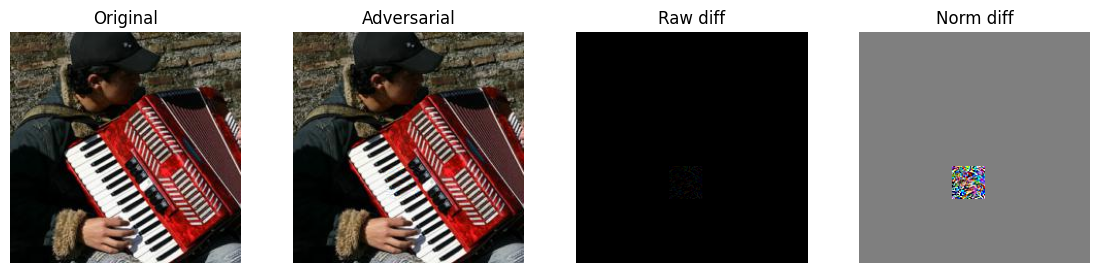

Top‑5 Original: [(401, 99.97320771217346), (881, 0.006146683153929189), (579, 0.0054672393162036315), (541, 0.0011557671314221807), (652, 0.0010711120012274478)]
Top‑5 Adversarial: [(401, 99.81756210327148), (881, 0.031507282983511686), (579, 0.024166482035070658), (652, 0.007921069482108578), (687, 0.006494656554423273)]


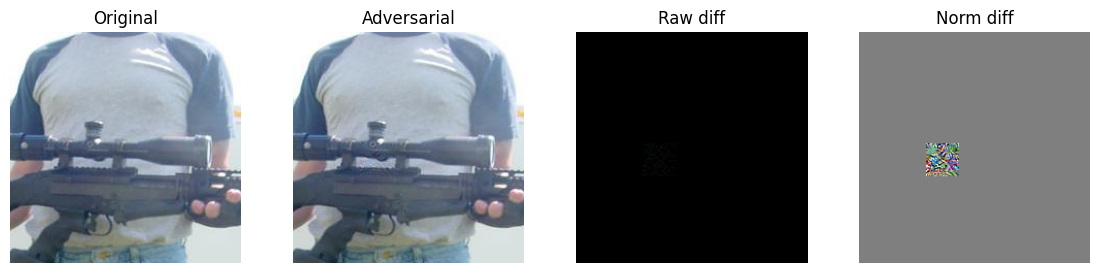

Top‑5 Original: [(413, 77.32294201850891), (764, 19.478987157344818), (465, 2.963506057858467), (652, 0.1414745580404997), (597, 0.030899600824341178)]
Top‑5 Adversarial: [(465, 66.46509766578674), (413, 21.837307512760162), (764, 10.09654849767685), (652, 0.8809780701994896), (597, 0.3131204517558217)]


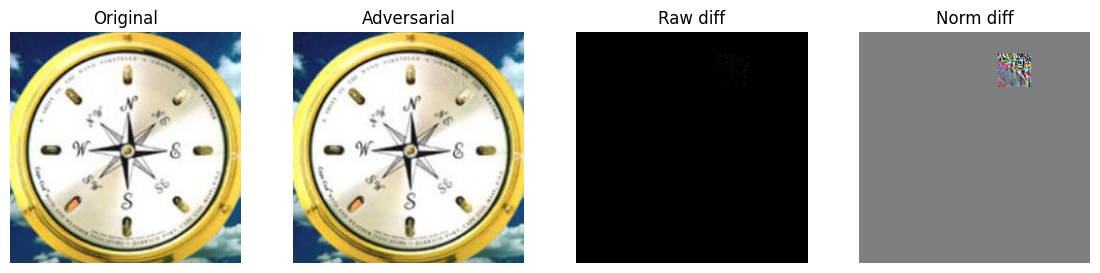

Top‑5 Original: [(635, 75.00854730606079), (409, 17.02546328306198), (426, 3.1481746584177017), (826, 3.137737885117531), (892, 0.6500579882413149)]
Top‑5 Adversarial: [(635, 67.68913269042969), (409, 24.470368027687073), (826, 5.674496293067932), (892, 0.8578932844102383), (426, 0.7088424172252417)]


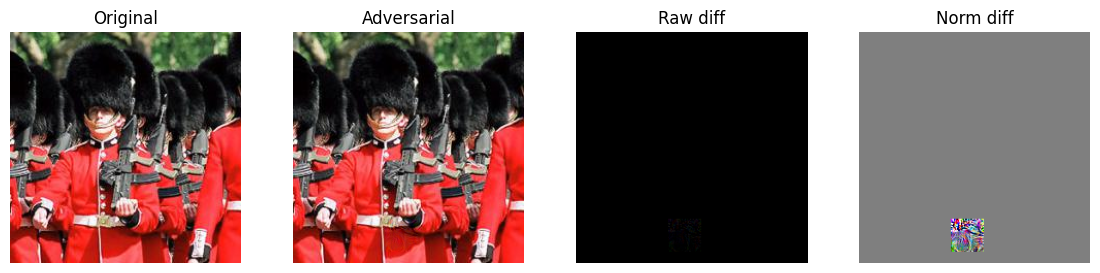

Top‑5 Original: [(439, 99.99955892562866), (223, 0.00020019629118905868), (244, 7.345163339778082e-05), (715, 2.6426729959894146e-05), (652, 2.1500336799817887e-05)]
Top‑5 Adversarial: [(439, 99.99730587005615), (223, 0.0016711142961867154), (244, 0.00031194142593449214), (537, 0.00010669667744878097), (369, 5.53378868062282e-05)]
Patch PGD — top‑1 46.60% | top‑5 82.00%


In [27]:
run_attack("Patch PGD", patch_pgd,
           save_dir = OUT_DIR / "Patch",
           eps = PATCH_EPS,
           alpha = PATCH_ALPHA,
           steps = PATCH_STEPS,
           size = PATCH_SIZE)

## 6. Transferability to DenseNet‑121

DenseNet‑121 is chosen to test how well crafted adversarial examples fool a different architecture.

In [34]:
def eval_dir(model, root):
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean.squeeze().tolist(), std.squeeze().tolist())
    ])
    ds_eval = ImageNetSubset(str(root), transform=tfm)   # <-- use custom class
    loader  = DataLoader(ds_eval, batch_size=64, shuffle=False)

    top1 = top5 = 0
    with torch.no_grad():
        for img, lbl in loader:
            a1, a5 = accuracy(model(img.to(device)), lbl.to(device))
            top1 += a1 * img.size(0)
            top5 += a5 * img.size(0)
    return top1 / len(ds_eval), top5 / len(ds_eval)

In [35]:
densenet = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device).eval()

# build directory list automatically
dir_list = [('Original', DATASET_DIR)] + sorted(
    [(p.name, p) for p in OUT_DIR.iterdir() if p.is_dir()],
    key=lambda x: x[0].lower()
)

for name, dirp in dir_list:
    t1, t5 = eval_dir(densenet, dirp)
    print(f'{name:<10}: top‑1 {t1:.2f}% | top‑5 {t5:.2f}%')

Original  : top‑1 74.80% | top‑5 93.60%
FGM_L2    : top‑1 67.20% | top‑5 91.40%
FGSM      : top‑1 70.80% | top‑5 92.20%
Patch     : top‑1 73.60% | top‑5 92.40%
PGD       : top‑1 73.00% | top‑5 93.20%


## Observations & Insights

| Model / Set                    | Top‑1 | Top‑5 | Δ Top‑1 vs Orig |
|--------------------------------|-------|-------|-----------------|
| **ResNet‑34 (white‑box)**      |       |       |                 |
| Original                       | **76.0 %** | **94.2 %** | — |
| FGSM ‖ ε∞ = 0.02               | 6.2 % | 35.4 % | **−69.8 pp** |
| FGM‑L2 ‖ ε₂ ≈ 0.02             | 74.4 % | 93.4 % | −1.6 pp |
| FGM‑L2 ‖ ε₂ = ε∞·√d (≈ 24.5)    | 6.0 % | 35.0 % | **−70.0 pp** |
| PGD‑∞ × 10 ‖ ε∞ = 0.02         | **0.2 %** | 12.4 % | **−75.8 pp** |
| Patch‑PGD 32² ‖ ε∞ = 0.3       | 46.6 % | ~82 % | −30 pp |
| **DenseNet‑121 (transfer)**    |       |       |                 |
| Original                       | **74.8 %** | **93.6 %** | — |
| FGSM (∞) from ResNet           | 70.8 % | 92.2 % | −4.0 pp |
| FGM‑L2 ‖ ε₂ ≈ 0.02             | 74.4 % | 93.4 % | −0.4 pp |
| FGM‑L2 ‖ ε₂ = ε∞·√d            | **67.2 %** | 91.4 % | **−7.6 pp** |
| PGD‑∞ × 10 from ResNet         | 73.0 % | 93.2 % | −1.8 pp |
| Patch‑PGD 32²                  | 73.6 % | 92.4 % | −1.2 pp |

*pp = percentage‑point drop*

### Key take‑aways

* **PGD‑∞ is catastrophic in white‑box** – ResNet‑34 collapses to *0.2 %* top‑1 after only 10 steps.

* **L₂ vs L∞ budgets**  
  *Using the *same* ε (0.02), L₂‑FGM barely changes accuracy (−1.6 pp).  
  Scaling L₂ by √d to equalize energy (ε₂ ≈ 24.5) makes it as effective as FGSM‑∞.*

* **Patch attack trade‑off**  
  Limiting perturbation to a 32 × 32 square decreases the effectiveness of the attack but we still observe a **30 pp** drop in accuracy.  
  Heat‑maps show noise is confined to the patch; logits often flip only when the patch covers salient object pixels.

* **Transfer robustness**  
  DenseNet‑121 loses at most **7.6 pp** (scaled L₂); PGD‑∞ and patch attacks hardly hurt it.  
  Gradient alignment across architectures is weak without momentum / input diversity.

* **Visualization sanity‑check**  
  Difference panels confirm pixel changes respect the ε‑ball; top‑5 readouts show either (i) confidence collapse to a wrong class or (ii) rank‑order swap of visually similar classes.